Source: https://www.kaggle.com/code/cookiefinder/wgan-cifar10

In [95]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_value_
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import RMSprop
import os
from IPython.display import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline


import statistics as stats
from scipy.spatial import distance
import cv2
import numpy as np
import math

from torchvision.utils import save_image
import tensorflow as tf
import torch
from torchsummary import summary

In [96]:
cifar10 = CIFAR10(root='data', 
              train=True, 
              download=True,
              transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

img, label = cifar10[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Files already downloaded and verified
Label:  6
tensor([[[-0.3725, -0.2392, -0.2941, -0.2314,  0.0745],
         [-0.1294,  0.1451,  0.0667,  0.2784,  0.3255],
         [ 0.0824,  0.6706,  0.3961,  0.4980,  0.6549],
         [ 0.2941,  0.7961,  0.4353,  0.4980,  0.8745],
         [ 0.5059,  0.4510,  0.1373,  0.5922,  0.7490]],

        [[-0.6863, -0.5843, -0.6471, -0.5608, -0.2863],
         [-0.5294, -0.3255, -0.3882, -0.0902, -0.0980],
         [-0.3804,  0.1765, -0.0353,  0.1765,  0.3255],
         [-0.1686,  0.3804,  0.0745,  0.2392,  0.6941],
         [ 0.1922,  0.1608, -0.2078,  0.2706,  0.5686]],

        [[-0.8980, -0.8667, -0.8667, -0.7647, -0.5529],
         [-0.8902, -0.8275, -0.8196, -0.3961, -0.4588],
         [-0.8510, -0.5373, -0.6784, -0.2314, -0.0431],
         [-0.6078, -0.2784, -0.5529, -0.1922,  0.3804],
         [-0.1137, -0.1608, -0.6000, -0.0510,  0.3333]]])


(tensor(-1.), tensor(1.))

In [97]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [98]:
def earthMoversDistance_calculation(true, fake, display=False):

    true_adjusted = true.reshape(64*32*32*3)
    fake_adjusted = fake.reshape(64*32*32*3)

    # Normalize true and fake
    true_adjusted = cv2.normalize(np.array(true_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    fake_adjusted = cv2.normalize(np.array(fake_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    true_adjusted = np.array([elem[0] for elem in true_adjusted]).reshape(64*32*32*3)
    fake_adjusted = np.array([elem[0] for elem in fake_adjusted]).reshape(64*32*32*3)

    if display: print(true_adjusted[0:1])
    if display: print(fake_adjusted[0:1])
    
    # Get JSD
    emd = stats.wasserstein_distance(true_adjusted, fake_adjusted)

    # Remove inf values
    #emd_adjusted = [v for v in emd if not math.isnan(v) and not math.isinf(v)]

    return emd #stats.mean(emd_adjusted)

# output = jsd_calculation(true, fake, display=False)
# print(output)

Label: 6


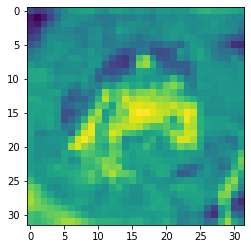

In [99]:
img_norm = denorm(img)
plt.imshow(img_norm[0])
print('Label:', label)

first batch
torch.Size([64, 3, 32, 32])
tensor([6, 6, 4, 4, 6, 5, 2, 7, 7, 3, 3, 6, 1, 8, 5, 0, 7, 1, 1, 2, 3, 8, 4, 5,
        8, 7, 7, 6, 1, 8, 8, 2, 6, 5, 9, 7, 2, 5, 2, 6, 3, 0, 2, 5, 5, 1, 6, 6,
        2, 8, 4, 4, 5, 1, 9, 4, 0, 1, 4, 9, 9, 3, 5, 6])


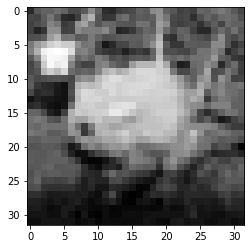

In [100]:
batch_size = 64
latent_size = 100
data_loader = DataLoader(cifar10, batch_size, shuffle=True, num_workers = 2, pin_memory = True)

for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [103]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [104]:
def wasserstein_loss(labels, output):
    return torch.mean(labels * output)

In [105]:
critic = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Linear(1,1)
        )

# Create the critic
critic.to(device)
  
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
critic.apply(weights_init)

# Print the critic
print(critic)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  (9): Linear(in_features=1, out_features=1, bias=True)
)


In [109]:
G = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
G.to(device)
G.apply(weights_init)

Sequential(
  (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): Tanh()
)

In [111]:
print("_______________________________________Critic")
print(summary(critic, (3,32,32)))
print("_______________________________________Generator")
print(summary(G, (100,4,4)))

_______________________________________Critic
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,200
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
            Conv2d-6            [-1, 256, 4, 4]         524,544
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           4,097
           Linear-10              [-1, 1, 1, 1]               2
Total params: 663,747
Trainable params: 663,747
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size

In [108]:
critic_optimizer = RMSprop(critic.parameters(), lr=5e-5)
g_optimizer = RMSprop(G.parameters(), lr=5e-5)
criterion = wasserstein_loss

In [77]:
def reset_grad():
    critic_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_critic(images, grad_clip = 0.01):
    # Create the labels which are later used as input for the BCE loss
    real_labels = -torch.ones(batch_size, 1, 1, 1).to(device)
    fake_labels = torch.ones(batch_size, 1, 1, 1).to(device)
        
    # Loss for real images
    outputs = critic(images)
    critic_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = G(z)
    outputs = critic(fake_images)
    critic_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    critic_loss = critic_loss_real + critic_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    critic_loss.backward()
    clip_grad_value_(critic.parameters(), grad_clip)
    # Adjust the parameters using backprop
    critic_optimizer.step()
    return critic_loss, real_score, fake_score                            

In [78]:
def train_generator(grad_clip = 0.01):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = G(z)
    labels = -torch.ones(batch_size, 1, 1, 1).to(device)
    g_loss = criterion(critic(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    clip_grad_value_(G.parameters(), grad_clip)
    g_optimizer.step()
    return g_loss, fake_images

In [79]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

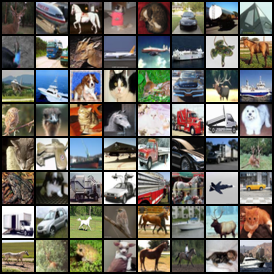

In [80]:
# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 3, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=8)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

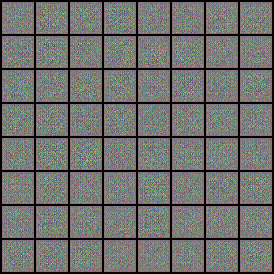

In [81]:
sample_vectors = torch.randn(batch_size, latent_size, 1, 1).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [82]:
%%time

num_epochs = 1000
d_losses, g_losses, real_scores, fake_scores, emd = [], [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device)
        if images.shape != torch.Size([64, 3, 32, 32]):
            continue
        # Train the discriminator and generator
        
        for i in range(5):    
            d_loss, real_score, fake_score = train_critic(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 10 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            emd_epoch = earthMoversDistance_calculation(images, fake_images)
            emd.append(emd_epoch)
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}, EMD: {:.2f}' 
                  .format(epoch, num_epochs, i+1, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item(), emd_epoch))
        break
        
    # Sample and save images
    save_fake_images(epoch+1)

CPU times: user 2min 30s, sys: 2min 26s, total: 4min 56s
Wall time: 4min 24s


In [83]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(critic.state_dict(), 'D.ckpt')

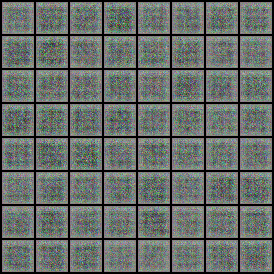

In [84]:
Image('./samples/fake_images-0010.png')

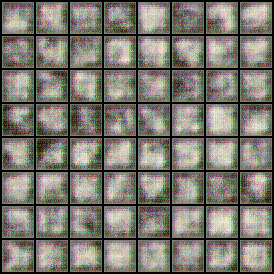

In [85]:
Image('./samples/fake_images-0050.png')

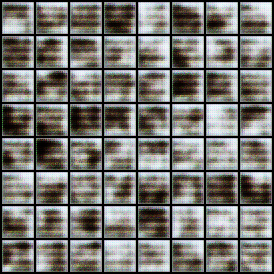

In [86]:
Image('./samples/fake_images-0100.png')

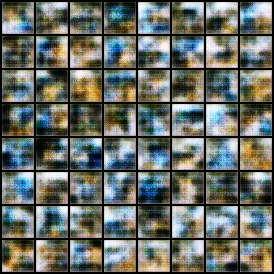

In [87]:
Image('./samples/fake_images-0300.png')

Text(0.5, 1.0, 'Losses')

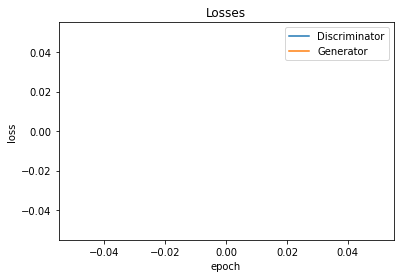

In [88]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [89]:
for i, data in enumerate(data_loader):
    print(data[0].shape)
    break

torch.Size([64, 3, 32, 32])


Text(0.5, 1.0, 'Scores')

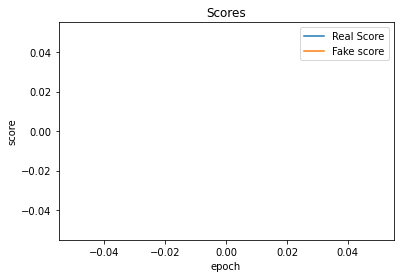

In [90]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')